In [8]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.preprocessing
import tensorflow as tf
from tensorflow.keras.layers import *
import sklearn.metrics
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math 
rcParams['figure.figsize']=20,10

dataset = pd.read_csv('BTC-USD.csv')

dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,13/12/2016,780.646973,788.460022,777.961975,780.556030,780.556030,81645600.0
1,14/12/2016,780.005005,782.033997,776.838989,781.481018,781.481018,75979000.0
2,15/12/2016,780.070007,781.434998,777.802002,778.088013,778.088013,81580096.0
3,16/12/2016,778.963013,785.031982,778.963013,784.906982,784.906982,83608200.0
4,17/12/2016,785.166016,792.508972,784.864014,790.828979,790.828979,78989800.0


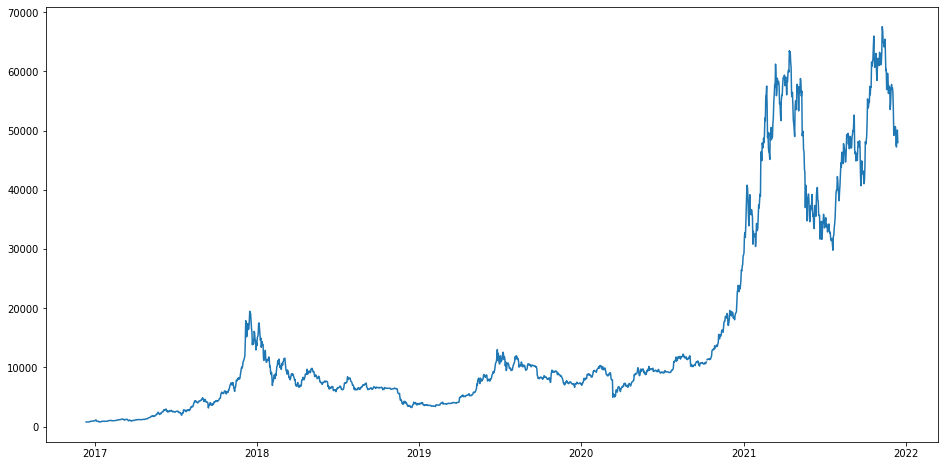

In [3]:
dataset["Date"]=pd.to_datetime(dataset.Date,format = "%d/%m/%Y")
dataset.index = dataset['Date']
    
plt.figure(figsize=(16,8))
#plt.legend
plt.plot(dataset["Close"],label='Close Price history') # arxiko diagramma dedomenwn

Epoch 1/15
29/29 [==============================] - 3s 35ms/step - loss: 0.0023
Epoch 2/15
29/29 [==============================] - 1s 35ms/step - loss: 3.3462e-04
Epoch 3/15
29/29 [==============================] - 1s 34ms/step - loss: 2.5165e-04
Epoch 4/15
29/29 [==============================] - 1s 32ms/step - loss: 2.3428e-04
Epoch 5/15
29/29 [==============================] - 1s 32ms/step - loss: 2.2227e-04
Epoch 6/15
29/29 [==============================] - 1s 31ms/step - loss: 1.8060e-04
Epoch 7/15
29/29 [==============================] - 1s 33ms/step - loss: 1.7291e-04
Epoch 8/15
29/29 [==============================] - 1s 33ms/step - loss: 1.8580e-04
Epoch 9/15
29/29 [==============================] - 1s 30ms/step - loss: 1.6098e-04
Epoch 10/15
29/29 [==============================] - 1s 31ms/step - loss: 1.4497e-04
Epoch 11/15
29/29 [==============================] - 1s 31ms/step - loss: 1.5248e-04
Epoch 12/15
29/29 [==============================] - 1s 32ms/step - loss: 1.55

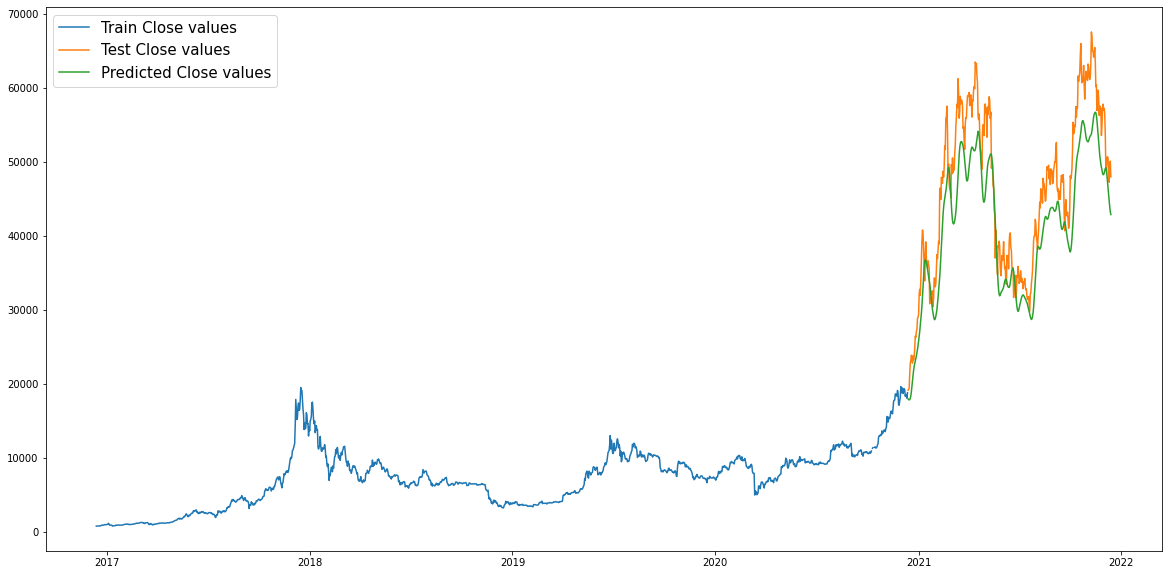

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 60, 50)            20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
new_dataset = pd.DataFrame(index=range(0,len(dataset)),columns=['Date','Close'])

for i in range(0,len(dataset)):
    new_dataset["Date"][i] = dataset['Date'][i]
    new_dataset["Close"][i] = dataset["Close"][i]    
   
# data normalization
scaler = sk.preprocessing.MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset = new_dataset.values


train_data = final_dataset[0:1461,:] # 80% training data
valid_data = final_dataset[1461:,:]   # 20% testing data 



scaler=sk.preprocessing.MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

# remove NaN values
scaled_data = scaled_data[~np.isnan(scaled_data)]
scaled_data = scaled_data.reshape(-1,1)

# pairnoume ta training data, 60 timesteps
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    

    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

    
# RNN implementation

"""

"""


model=tf.keras.Sequential()
model.add(LSTM(units = 50,return_sequences = True,input_shape=(x_train_data.shape[1],1))) # input layer
model.add(LSTM(units = 50,return_sequences = True)) # 1o hidden layer
model.add(LSTM(units = 50)) # 2o hidden layer
model.add(Dense(1)) # output layer

model.compile(loss='mean_squared_error',optimizer='adam')
model_log = model.fit(x_train_data,y_train_data,epochs=15,batch_size=50) # mini batch size 50.


# Dense NN implementation
"""
model = tf.keras.Sequential() # aplo NN implementation
model.add(Conv1D(filters=64, kernel_size=2, activation='relu',input_shape = (x_train_data.shape[1],1)))
model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Flatten())
#model.add(Dense(50,input_dim = 60,activation = 'relu')) # input layer
model.add(Dense(50,activation = 'relu')) # 1o hidden layer
model.add(Dense(50,activation = 'relu')) # 2o hidden layer
model.add(Dense(1,activation = 'sigmoid')) # output layer (xrhsimopoioume sigmoid gia to epithymito apotelesma)

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam())

model_log = model.fit(x_train_data, y_train_data, epochs = 1, batch_size = 50) # mini batch me 50 ypodeigmata
"""



# etoimasia twn testing data.

test_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)


X_test = []
for i in range(60,test_data.shape[0]):
    X_test.append(test_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#model.fit(X_train, y_train)
ypred = model.predict(X_test)
ypred = scaler.inverse_transform(ypred)


# provlepsh timhs bitcoin vasismenh stis times kleisimatos twn teleytaiwn 50 hmerwn
train_data = new_dataset[:1461].copy()
test_data = new_dataset[1461:].copy()
test_data['Predictions'] = ypred


# remove NaN values
#train_data = train_data[~np.isnan(train_data)]
#test_data = test_data[~np.isnan(test_data)]
plt.plot(train_data['Close'], label = "Train Close values")
plt.plot(test_data[['Close']] , label = "Test Close values")
plt.plot(test_data[['Predictions']], label = "Predicted Close values")
plt.legend(loc='upper left', fontsize=15)
plt.show()

print(model.summary())

In [9]:
print("R2 score is : ", sklearn.metrics.r2_score(valid_data,ypred))
print("RMSE is : ", math.sqrt(sklearn.metrics.mean_squared_error(valid_data,ypred)))

R2 score is :  0.6939222930307707
RMSE is :  6127.22627648844
